In [5]:
# --- Basic Imports ---
from utils import *
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, log_loss)

model_type = 'Baseline'
path = MODEL_DIR+model_type

os.makedirs(path, exist_ok=True)

In [6]:
df = pd.read_csv(os.path.join(SILVER_PATH, 'base_dataset.csv'), sep=';')

In [7]:
# --- 1. Column groups ---
categorical_cols = [
    'job', 'marital', 'education', 'default',
    'housing', 'loan', 'contact', 'poutcome'
]

numeric_cols = [
    'age', 'month', 'day_of_week', 'campaign',
    'pdays', 'previous',
    'emp_var_rate', 'cons_price_idx', 'cons_conf_idx',
    'euribor3m', 'nr_employed'
]

# --- 2. One-hot encode ---
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
bool_cols = df_encoded.select_dtypes(include=['bool']).columns
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)

# 1. Prepare X for sklearn LR
X_shap = df_encoded.drop(columns=['y'])
bool_cols = X_shap.select_dtypes(include=['bool']).columns
X_shap[bool_cols] = X_shap[bool_cols].astype(int)

y = df_encoded['y']

# --- 3. Fit logistic regression (baseline, raw) ---
lr = LogisticRegression(
    max_iter=5000,
    solver='lbfgs',
    penalty='l2',
    C=1.0,
    n_jobs=-1
)
lr.fit(X_shap, y)

# --- 4. SHAP using correct masker ---
masker = shap.maskers.Independent(X_shap)
explainer = shap.LinearExplainer(lr, masker)

# --- 5. Compute SHAP values ---
shap_values = explainer(X_shap)

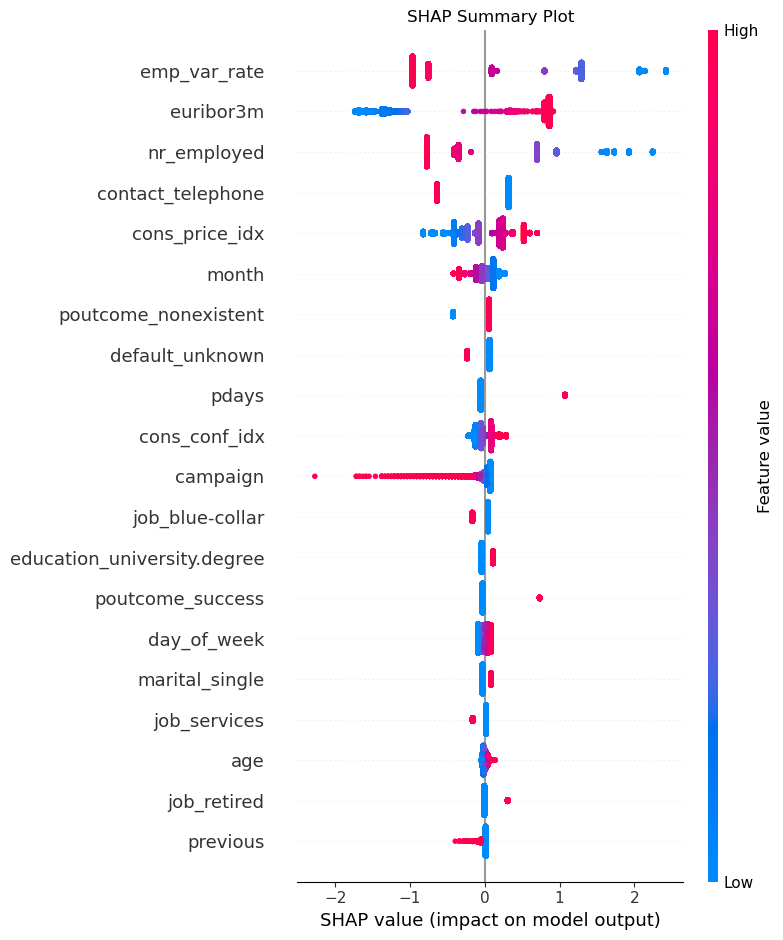

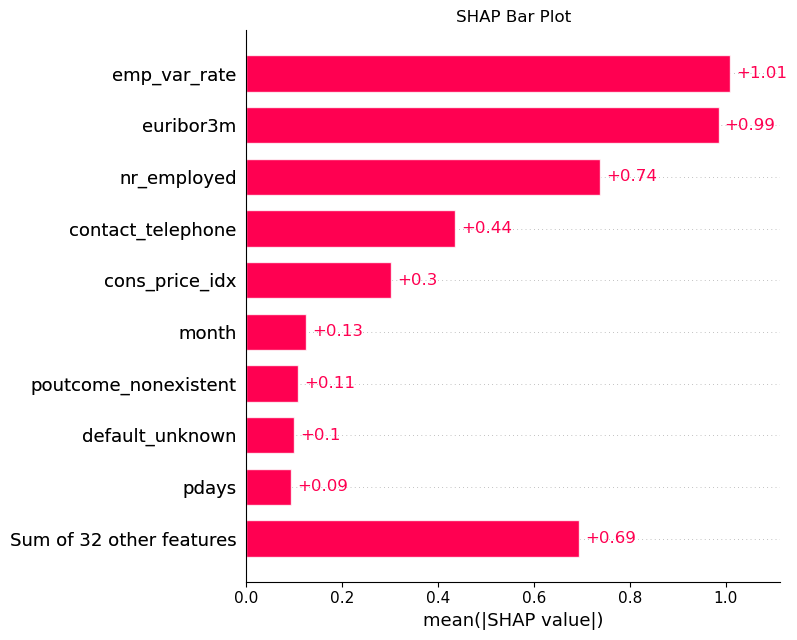

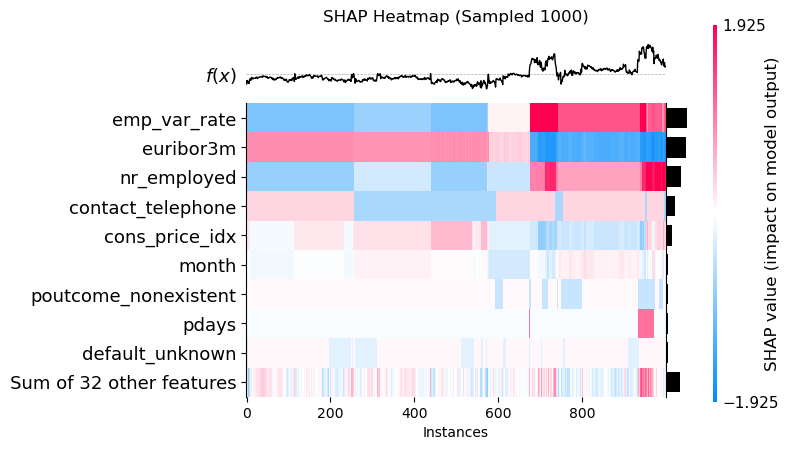

In [8]:
# --- 6. Summary plot ---
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_shap, show=False)
plt.title("SHAP Summary Plot")
plt.tight_layout()
plt.savefig(f"{path}/summary_plot.png", dpi=300)
plt.show()


# --- 7. Bar plot ---
plt.figure(figsize=(9, 6))
shap.plots.bar(shap_values, show=False)
plt.title("SHAP Bar Plot")
plt.tight_layout()
plt.savefig(f"{path}/bar_plot.png", dpi=300)
plt.show()


# --- 8. Heatmap plot (sampled) ---
idx = np.random.choice(len(X_shap), size=1000, replace=False)
shap_values_sampled = shap_values[idx]

plt.figure(figsize=(12, 6))
shap.plots.heatmap(shap_values_sampled, show=False)
plt.title("SHAP Heatmap (Sampled 1000)")
plt.tight_layout()
plt.savefig(f"{path}/heatmap_plot.png", dpi=300)
plt.show()


In [9]:
# --- 9. Predict probabilities and classes ---
y_pred_proba = lr.predict_proba(X_shap)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

# --- 10. Metrics dict ---
metrics = {
    "AUC": roc_auc_score(y, y_pred_proba),
    "Accuracy": accuracy_score(y, y_pred),
    "Precision": precision_score(y, y_pred),
    "Recall": recall_score(y, y_pred),
    "F1": f1_score(y, y_pred),
    "LogLoss": log_loss(y, y_pred_proba)
}

# --- 11. Save metrics ---
save_metrics(model_type, "logistic_regression_baseline", metrics)

Metrics saved for logistic_regression_baseline → ../97-model_metrics/Baseline/logistic_regression_baseline_metrics.csv
